# Value Investor

- Background:


We are a portfolio investment company and we make investments in the emerging markets around the world. Our company profits by investing in profitable companies, buying, holding and selling company stocks based on value investing principles.


Our goal is to establish a robust intelligent system to aid our value investing efforts using stock market data. We make investment decisions and based on intrinsic value of companies and do not trade on the basis of daily market volatility. Our profit realization strategy typically involves weekly, monthly and quarterly performance of stocks we buy or hold.


- Data Description:


You are given a set of portfolio companies trading data from emerging markets including 2020 Q1-Q2-Q3-Q4 2021 Q1 stock prices. Each company stock is provided in different sheets. Each market's operating days varies based on the country of the company and the market the stocks are exchanged. Use only 2020 data and predict with 2021 Q1 data.


- Goal(s):


Predict stock price valuations on a daily, weekly and monthly basis. Recommend BUY, HOLD, SELL decisions. Maximize capital returns, minimize losses. Ideally a loss should never happen. Minimize HOLD period.


- Success Metrics:


Evaluate on the basis of capital returns. Use Bollinger Bands to measure your systems effectiveness.

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

## Read Data

The last row of the 'csv' file contains following statistics about the 'Price' column, i.e. highest price, lowest price, difference between highest and lowest price, average price and percentage change in price. `skipfooter` attribute of read_csv is used to remove that line from dataframe.

In [2]:
df = pd.read_csv('2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv', skipfooter=1, engine='python').iloc[::-1]

In [3]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
310,"Jan 03, 2020",255.00,255.99,258.19,253.70,35.85M,0.10%
309,"Jan 06, 2020",253.90,254.75,254.84,251.40,22.35M,-0.43%
308,"Jan 08, 2020",259.15,253.57,259.15,253.03,40.82M,2.07%
307,"Jan 09, 2020",257.99,259.40,261.76,257.01,38.33M,-0.45%
306,"Jan 10, 2020",258.19,257.86,259.25,256.88,18.85M,0.08%


## Data Exploration

In [4]:
df.describe()

,Price,Open,High,Low
count,311.000000,311.000000,311.000000,311.000000
mean,234.524019,234.417846,237.314759,231.366141
std,32.079847,32.058167,32.075624,32.076603
min,174.270000,175.000000,182.200000,172.150000
25%,207.700000,207.215000,209.660000,204.475000
50%,229.140000,229.080000,231.950000,226.860000
75%,264.380000,263.885000,267.255000,261.110000
max,293.300000,294.860000,296.070000,291.500000


The 'Vol.' column is string variable with 'M' as suffix. Let's remove the 'M' and convert it to float. Similar to 'Vol.' column, '%' symbol is removed from 'Change %' column and convert it to float type.

In [5]:
df['Vol.'] = df['Vol.'].apply(lambda x: float(x[:-1]))
df['Change %'] = df['Change %'].apply(lambda x: float(x[:-1]))

In [6]:
df.describe()

,Price,Open,High,Low,Vol.,Change %
count,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000
mean,234.524019,234.417846,237.314759,231.366141,73.056977,0.066817
std,32.079847,32.058167,32.075624,32.076603,38.058095,2.193093
min,174.270000,175.000000,182.200000,172.150000,8.760000,-9.570000
25%,207.700000,207.215000,209.660000,204.475000,47.670000,-1.010000
50%,229.140000,229.080000,231.950000,226.860000,66.260000,0.040000
75%,264.380000,263.885000,267.255000,261.110000,85.120000,1.295000
max,293.300000,294.860000,296.070000,291.500000,263.040000,12.900000


<Axes: xlabel='Date'>

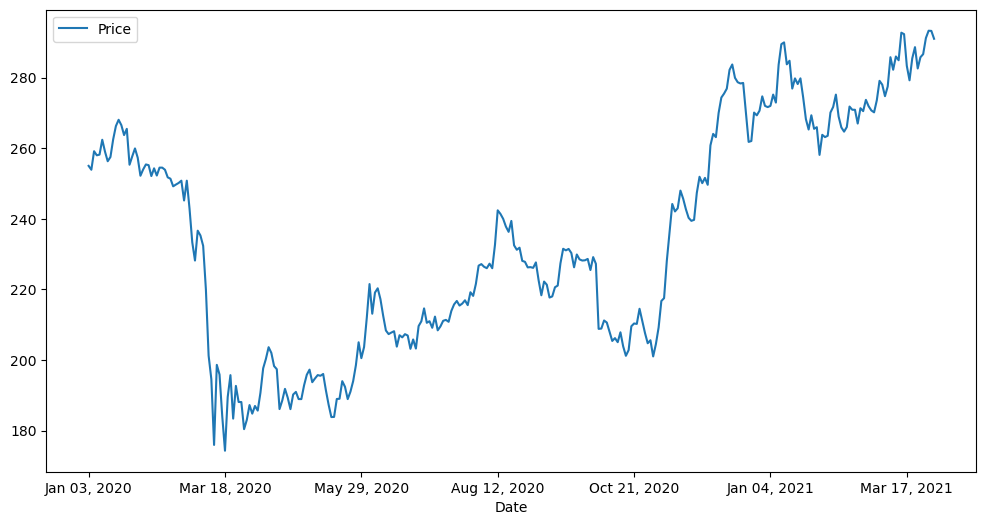

In [7]:
df.plot(x='Date', y='Price', figsize=(12,6))

In [8]:
df["Date"]=pd.to_datetime(df.Date,format="%b %d, %Y")

In [9]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
310,2020-01-03,255.00,255.99,258.19,253.70,35.85,0.10
309,2020-01-06,253.90,254.75,254.84,251.40,22.35,-0.43
308,2020-01-08,259.15,253.57,259.15,253.03,40.82,2.07
307,2020-01-09,257.99,259.40,261.76,257.01,38.33,-0.45
306,2020-01-10,258.19,257.86,259.25,256.88,18.85,0.08


## Data Preprocessing

Set target variable and the input features

In [10]:
output = pd.DataFrame(df['Price'])
input_cols = ['Open', 'High', 'Low', 'Vol.', 'Change %']

In [11]:
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[input_cols])
feature_transform= pd.DataFrame(columns=input_cols, data=feature_transform, index=df.index)
feature_transform.head()

,Open,High,Low,Vol.,Change %
310,0.675705,0.667340,0.683284,0.106536,0.430352
309,0.665360,0.637920,0.664013,0.053445,0.406765
308,0.655515,0.675771,0.677671,0.126081,0.518024
307,0.704155,0.698691,0.711018,0.116289,0.405874
306,0.691307,0.676649,0.709929,0.039681,0.429462


In [12]:
len_train = 250
x_train, y_train = df.iloc[:len_train][input_cols], df.iloc[:len_train]['Price']
x_test, y_test = df.iloc[len_train:][input_cols], df.iloc[len_train:]['Price']

In [13]:
trainX =np.array(x_train)
testX =np.array(x_test)
x_train = trainX.reshape(x_train.shape[0], 1, x_train.shape[1])
x_test = testX.reshape(x_test.shape[0], 1, x_test.shape[1])

## LSTM Model

Building the LSTM Model

In [14]:
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')

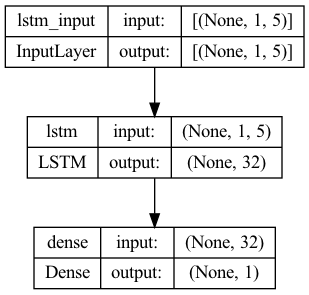

In [15]:
plot_model(lstm, show_shapes=True, show_layer_names=True)

## Model Training

In [16]:
history=lstm.fit(x_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100


2023-12-13 16:42:21.097752: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


32/32 [==============================] - 1s 762us/step - loss: 51854.6094
Epoch 2/100
32/32 [==============================] - 0s 627us/step - loss: 37908.2227
Epoch 3/100
32/32 [==============================] - 0s 672us/step - loss: 20609.1816
Epoch 4/100
32/32 [==============================] - 0s 703us/step - loss: 6936.3179
Epoch 5/100
32/32 [==============================] - 0s 715us/step - loss: 1308.5929
Epoch 6/100
32/32 [==============================] - 0s 534us/step - loss: 270.2491
Epoch 7/100
32/32 [==============================] - 0s 553us/step - loss: 171.5532
Epoch 8/100
32/32 [==============================] - 0s 550us/step - loss: 90.6215
Epoch 9/100
32/32 [==============================] - 0s 568us/step - loss: 55.4564
Epoch 10/100
32/32 [==============================] - 0s 546us/step - loss: 46.6110
Epoch 11/100
32/32 [==============================] - 0s 535us/step - loss: 33.4501
Epoch 12/100
32/32 [==============================] - 0s 489us/step - loss: 41.414

32/32 [==============================] - 0s 565us/step - loss: 9.8869
Epoch 99/100
32/32 [==============================] - 0s 562us/step - loss: 8.9283
Epoch 100/100
32/32 [==============================] - 0s 567us/step - loss: 8.5859


In [17]:
y_pred= lstm.predict(x_test)

2/2 [==============================] - 0s 5ms/step


In [18]:
print('Test RMSE :', np.sqrt(np.mean((y_pred-np.array(y_test))**2)))

Test RMSE : 13.073294175159122


## Stock Price Predictions

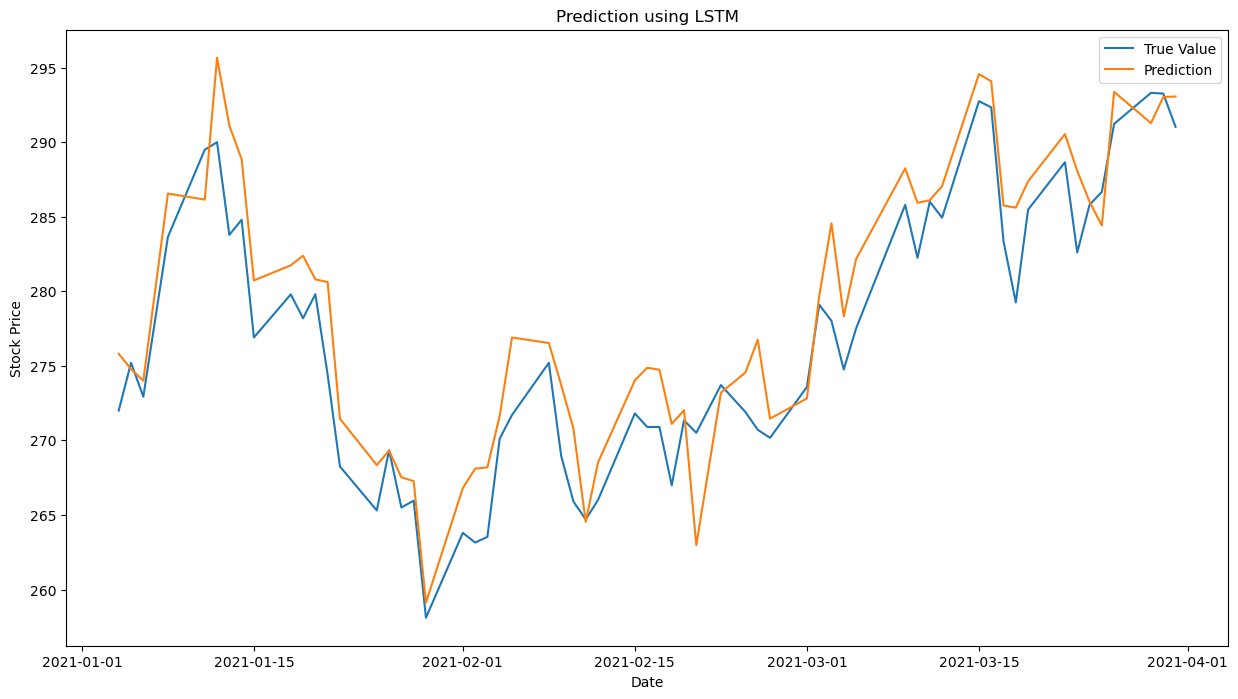

In [19]:
plt.figure(figsize=(15, 8))
plt.plot(df.iloc[len_train:]['Date'], y_test, label='True Value')
plt.plot(df.iloc[len_train:]['Date'], y_pred, label='Prediction')
plt.title("Prediction using LSTM")
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In order to recommend decisions (BUY, SELL, HOLD) using the model prediction. A simple and naive strategy adopted here is to

- BUY: if stock price decreased and going up
- SELL: if stock price increase and going down
- HOLD: if stock price increased and still increasing

In [20]:
def naive_strategy(prices):
    prediction_recommendation = []
    profit = 0
    stock_indicator = False
    
    if prices[0] < prices[1]:
        prediction_recommendation.append('BUY')
        buy_price = prices[0]
        stock_indicator = True
    else:
        prediction_recommendation.append('HOLD')
        
    for i in range(1, len(prices)-1):
        if prices[i] < prices[i-1] and prices[i] < prices[i+1]:
            prediction_recommendation.append('BUY')
            buy_price = prices[i]
            stock_indicator = True
        elif prices[i] > prices[i-1] and prices[i] > prices[i+1] and stock_indicator:
            prediction_recommendation.append('SELL')
            profit += prices[i] - buy_price
            stock_indicator = False
        else:
            prediction_recommendation.append('HOLD')
            
    prediction_recommendation.append('HOLD')
        
    return prediction_recommendation, profit

In [21]:
recommendation, expected_profit = naive_strategy(np.array(y_pred)[:, 0])
print('Expected profit using model predictions: ', expected_profit)

Expected profit using model predictions:  113.04891967773438


In [22]:
dream_recommendation, dream_profit = naive_strategy(np.array(y_test))
print('Dream profit using true stock prices: ', dream_profit)

Dream profit using true stock prices:  114.31


In [23]:
ans = df.iloc[len_train:].copy()
ans['Naive Recommendation'] = recommendation
ans

,Date,Price,Open,High,Low,Vol.,Change %,Naive Recommendation
60,2021-01-04,272.00,274.67,276.60,270.61,48.92,0.13,HOLD
59,2021-01-05,275.20,272.69,275.70,270.28,45.58,1.18,HOLD
58,2021-01-06,272.93,275.94,275.94,271.62,40.95,-0.82,BUY
57,2021-01-08,283.64,275.11,283.99,275.11,88.93,3.92,SELL
56,2021-01-11,289.49,282.86,292.95,279.48,112.35,2.06,BUY
...,...,...,...,...,...,...,...,...
4,2021-03-25,286.66,286.50,287.03,283.85,35.22,0.30,BUY
3,2021-03-26,291.22,288.63,292.75,288.32,56.07,1.59,SELL
2,2021-03-29,293.30,289.72,294.09,289.26,43.68,0.71,BUY
1,2021-03-30,293.25,294.86,295.72,291.50,38.81,-0.02,HOLD


## Bollinger Bands

Calculation of Bollinger bands.

$$ U = MA(TP, n) + m \times \sigma(TP, n) $$
$$ L = MA(TP, n) - m \times \sigma(TP, n) $$

where,

U: Bollinger upper limit

L: Bollinger lower limit

MA(TP, n): Average over last n periods of TP values

TP: Typical price,  (low + high + close)/3

n: Smoothing period (typical 20)

m: Number of standard deviation (typically 2)

$\sigma(TP, n)$: Standard deviation over last n periods of TP values

In [24]:
smoothing_period = 20
m_std = 2
y_val = np.array((df.Price + df.High + df.Low)/3)[250-smoothing_period:]

In [25]:
moving_avg, bol_upper, bol_lower = [], [], []
for i in range(len(y_val)-smoothing_period):
    tmp = y_val[i:i+smoothing_period]
    moving_avg.append(np.mean(tmp))
    sigma = np.std(tmp)
    bol_upper.append(moving_avg[-1]+m_std*sigma)
    bol_lower.append(moving_avg[-1]-m_std*sigma)

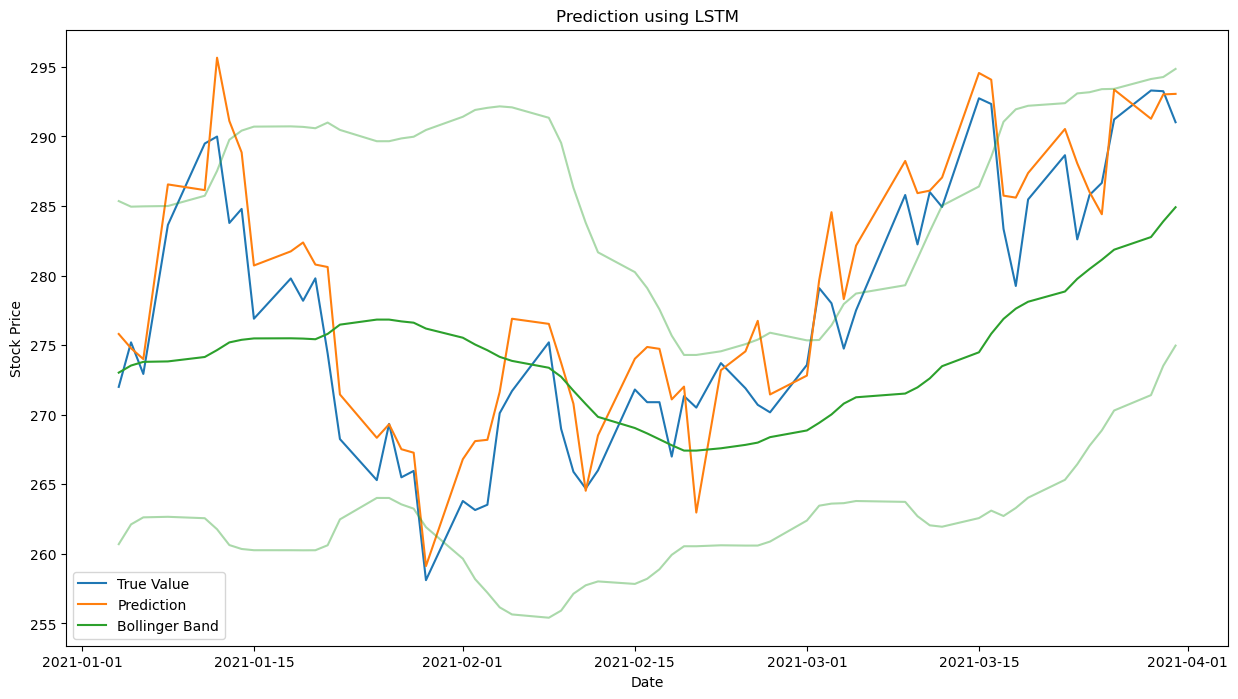

In [26]:
plt.figure(figsize=(15, 8))
plt.plot(df.iloc[len_train:]['Date'], y_test, label='True Value')
plt.plot(df.iloc[len_train:]['Date'], y_pred, label='Prediction')
plt.plot(df.iloc[len_train:]['Date'], moving_avg, label='Bollinger Band')
plt.plot(df.iloc[len_train:]['Date'], bol_upper, alpha=0.4, color='C2')
plt.plot(df.iloc[len_train:]['Date'], bol_lower, alpha=0.4, color='C2')
plt.title("Prediction using LSTM")
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Prices can "walk the band" during a strong down- or uptrend. This means that there are repeated instances of a price touching or breaking through the lower or upper band. That's why you may not want to take action when the price touches either band—you might, instead, prefer to wait and look for chart patterns like the "double bottom," a "classic M top," or a "three pushes to high" formation.

- Double bottom: This occurs when there is a fall in price, followed by a rise, followed by another fall that is close to the previous low, and finally another rise.

- Classic M top: This shape is formed by a push to a high, followed by sell-off reaction, and then a test of the previous high. The second high can be higher or lower than the first high.

- Three pushes to high: A top often develops as a leading edge of a larger, longer topping formation. The way it forms is typically like this: The first push creates a new high outside the upper band; the second push makes a new high and touches the upper band; the third push makes a new high, but within the upper band.

Based on these formation and observation, 

- A double bottom can be observed between 2021-02-01 and 2021-02-15, which suggests an upward trend and recommend buying (`BUY`) stock. 

- A classic M top can be observed between 2021-03-01 and 2021-03-15, which recommend selling (`SELL`) stock.